# 2つの正規分布の直積モデルのベイズ統計によるWelchのt検定の再現

* 黒木玄
* 2022-09-16, 2022-09-22

2つの正規分布の直積モデルのベイズ統計でWelchのt検定が近似的に再現されることを確認する.

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#分散が異なる２つの正規分布でデータを生成した場合" data-toc-modified-id="分散が異なる２つの正規分布でデータを生成した場合-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>分散が異なる２つの正規分布でデータを生成した場合</a></span></li><li><span><a href="#異なる２つのガンマ分布でデータを生成した場合" data-toc-modified-id="異なる２つのガンマ分布でデータを生成した場合-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>異なる２つのガンマ分布でデータを生成した場合</a></span></li><li><span><a href="#Welchのt検定での自由度の分布" data-toc-modified-id="Welchのt検定での自由度の分布-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Welchのt検定での自由度の分布</a></span></li></ul></div>

In [1]:
using Distributions
using QuadGK
using Random
Random.seed!(4649373)
using StatsBase: ecdf
using StatsPlots
default(fmt=:png, titlefontsize=10, plot_titlefontsize=10,
    tickfontsize=6, guidefontsize=9)

distname(dist) = replace(string(dist), r"{[^}]*}"=>"")

distname (generic function with 1 method)

In [2]:
# 通常のWelchのt検定

function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [3]:
# Welchのt検定を正確に再現する Δμ に関する分布

function posterior_welch(m, x̄, sx², n, ȳ, sy²)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    SEhat = √(sx²/m + sy²/n)
    x̄ - ȳ + SEhat*TDist(ν)
end

function posterior_welch(x, y)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    posterior_welch(m, x̄, sx², n, ȳ, sy²)
end

posterior_welch (generic function with 2 methods)

次のセルの内容に関する詳しい説明については

* https://github.com/genkuroki/public/blob/main/0036/InverseGammaNormal%20conjugate%20prior%20of%20normal%20distribution.ipynb
* https://github.com/genkuroki/public/blob/main/0036/InverseGammaNormal%20conjugate%20prior%20of%20normal%20distribution.pdf

を参照せよ.

In [4]:
# 1つの正規分布モデルの共役事前分布のベイズ更新

function bayesian_update(μ₀, v₀, κ, θ, n, x̄, σ̂²)
    μ₀_new = (μ₀/v₀ + n*x̄)/(1/v₀ + n)
    v₀_new = 1/(1/v₀ + n)
    κ_new = κ + n/2
    θ_new = θ + (n/2)*(σ̂² + ((x̄ - μ₀)^2/v₀)/(1/v₀ + n))
    μ₀_new, v₀_new, κ_new, θ_new
end

function bayesian_update(μ₀, v₀, κ, θ, y)
    n, ȳ, σ̂² = length(y), mean(y), var(y; corrected=false)
    bayesian_update(μ₀, v₀, κ, θ, n, ȳ, σ̂²)
end

# μに関する事前事後分布
posterior_μ(μ₀, v₀, κ, θ) = μ₀ + √(θ/κ*v₀)*TDist(2κ)

# 事前予測分布
preddist(μ₀, v₀, κ, θ) = μ₀ + √(θ/κ*(1 + v₀))*TDist(2κ)

preddist (generic function with 1 method)

In [5]:
# (μx, μy) に関する事後分布

function posterior_μxμy(m, x̄, σ̂x², n, ȳ, σ̂y²;
        μx₀=0, vx₀=Inf, κx=0, θx=0, μy₀=0, vy₀=Inf, κy=0, θy=0)
    μx₀_new, vx₀_new, κx_new, θx_new = bayesian_update(μx₀, vx₀, κx, θx, m, x̄, σ̂x²)
    μy₀_new, vy₀_new, κy_new, θy_new = bayesian_update(μy₀, vy₀, κy, θy, n, ȳ, σ̂y²)
    posterior_μx = posterior_μ(μx₀_new, vx₀_new, κx_new, θx_new)
    posterior_μy = posterior_μ(μy₀_new, vy₀_new, κy_new, θy_new)
    posterior_μx, posterior_μy
end

function posterior_μxμy(x, y;
        μx₀=0, vx₀=Inf, κx=0, θx=0, μy₀=0, vy₀=Inf, κy=0, θy=0)
    m, x̄, σ̂x² = length(x), mean(x), var(x; corrected=false)
    n, ȳ, σ̂y² = length(y), mean(y), var(y; corrected=false)
    posterior_μxμy(m, x̄, σ̂x², n, ȳ, σ̂y²; μx₀, vx₀, κx, θx, μy₀, vy₀, κy, θy)
end

function rand_posterior_Δμ(x, y; L=10^6,
        μx₀=0, vx₀=Inf, κx=0, θx=0, μy₀=0, vy₀=Inf, κy=0, θy=0)
    posterior_μx, posterior_μy =
        posterior_μxμy(x, y; μx₀, vx₀, κx, θx, μy₀, vy₀, κy, θy)
    [rand(posterior_μx) - rand(posterior_μy) for _ in 1:L]
end

rand_posterior_Δμ (generic function with 1 method)

In [6]:
# X ~ distx, Y ~ disty のときの X - Y が従う分布の密度函数

function pdf_diff(distx, disty, Δ)
    K(y) = pdf(distx, y+Δ) * pdf(disty, y)
    quadgk(K, extrema(disty)...)[1]
end

pdf_diff (generic function with 1 method)

In [7]:
function plot_bayesian_welch(x, y; L=10^6, title="m=$(length(x)), n=$(length(y))")
    posterior_μx, posterior_μy = posterior_μxμy(x, y)
    pdf_Δμ(Δμ) = pdf_diff(posterior_μx, posterior_μy, Δμ)
    post_welch = posterior_welch(x, y)
    xlim = quantile.(post_welch, (0.0001, 0.9999))
    plot(legend=:outertop)
    plot!(pdf_Δμ, xlim...; norm=true, label="posterior of Δμ w.r.t. the flat prior")
    plot!(post_welch, xlim...; label="\"posterior\" reproducing Welch t-test", ls=:dash)
    plot!(xguide="Δμ")
    plot!(; title, xlim)
end

function plot_bayesian_welch(distx, m, disty, n; L=10^6,
        x = rand(distx, m), y = rand(disty, n))
    @show mean(distx) - mean(disty)
    @show var(distx) var(disty)
    @show mean(x) - mean(y)
    @show var(x) var(y)
    @show degree_of_freedom_welch(x, y)
    @show min(m,n) - 1, m + n - 2
    title="$(distname(distx)), m=$m\n$(distname(disty)), n=$n"
    plot_bayesian_welch(x, y; L, title)
end

plot_bayesian_welch (generic function with 2 methods)

## 分散が異なる２つの正規分布でデータを生成した場合

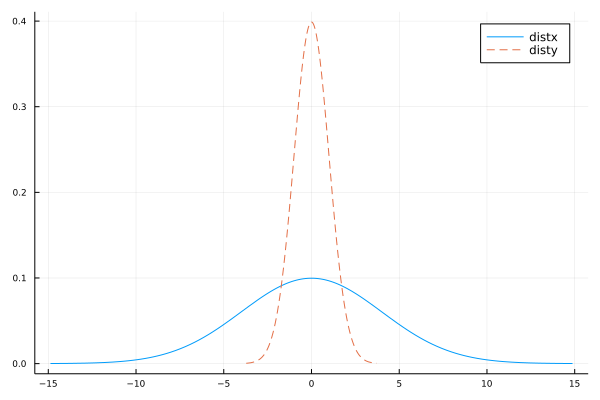

In [8]:
distx = Normal(0, 4)
disty = Normal(0, 1)
plot(distx; label="distx")
plot!(disty; label="disty", ls=:dash)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = -0.3211542479019229
var(x) = 17.237996729825525
var(y) = 1.0731250836219475
degree_of_freedom_welch(x, y) = 6.744157641337655
(min(m, n) - 1, (m + n) - 2) = (6, 12)


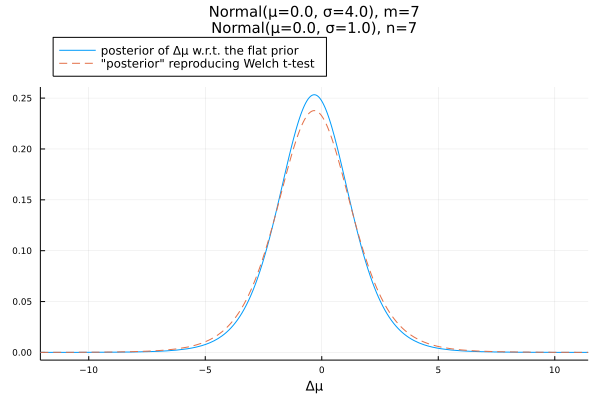

In [9]:
plot_bayesian_welch(distx, 7, disty, 7)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.7677342545789224
var(x) = 15.732098039173188
var(y) = 1.3033183211091064
degree_of_freedom_welch(x, y) = 11.518022822789424
(min(m, n) - 1, (m + n) - 2) = (4, 13)


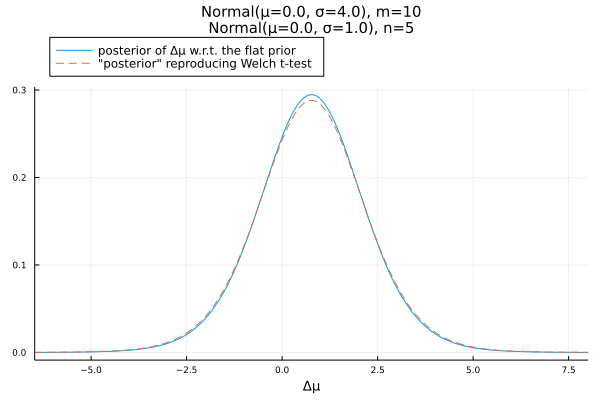

In [10]:
plot_bayesian_welch(distx, 10, disty, 5)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = -1.5224573578229603
var(x) = 9.407628082708838
var(y) = 0.8211247071425152
degree_of_freedom_welch(x, y) = 4.353064975700501
(min(m, n) - 1, (m + n) - 2) = (4, 13)


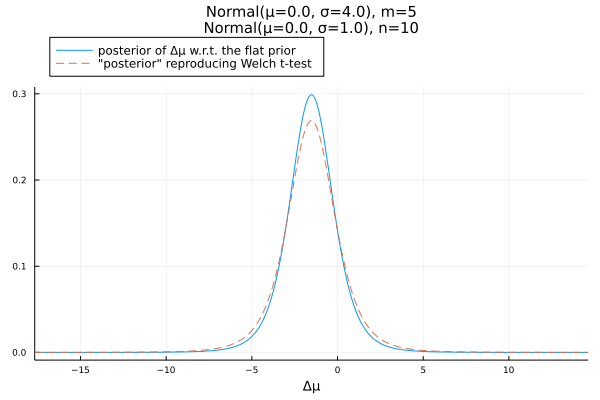

In [11]:
plot_bayesian_welch(distx, 5, disty, 10)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 1.0306311204631988
var(x) = 21.752549063516163
var(y) = 0.9029658337231223
degree_of_freedom_welch(x, y) = 15.160303181621106
(min(m, n) - 1, (m + n) - 2) = (14, 28)


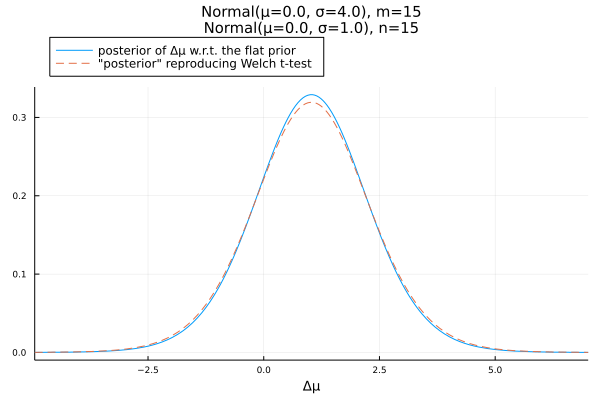

In [12]:
plot_bayesian_welch(distx, 15, disty, 15)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 1.4086324205673817
var(x) = 14.784984604317541
var(y) = 1.0928063883705097
degree_of_freedom_welch(x, y) = 23.928695652311735
(min(m, n) - 1, (m + n) - 2) = (9, 28)


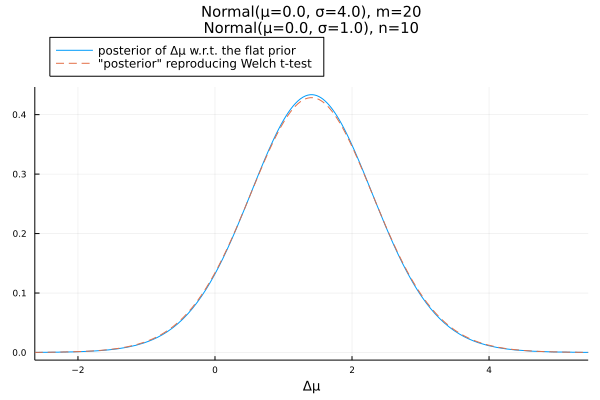

In [13]:
plot_bayesian_welch(distx, 20, disty, 10)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = -1.67233937646867
var(x) = 23.40523335213445
var(y) = 0.7383876772021138
degree_of_freedom_welch(x, y) = 9.285076774941
(min(m, n) - 1, (m + n) - 2) = (9, 28)


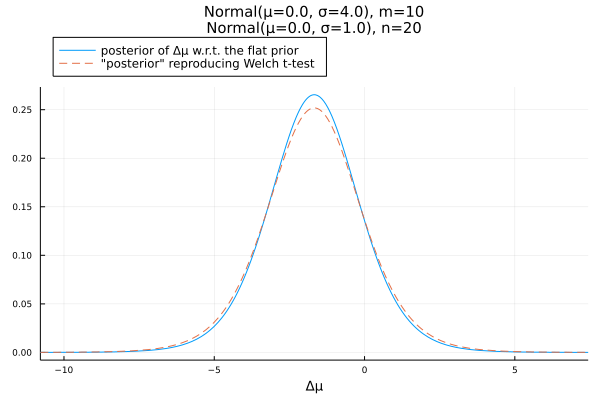

In [14]:
plot_bayesian_welch(distx, 10, disty, 20)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = -0.11536080957066819
var(x) = 18.45703262845276
var(y) = 1.3269458827430953
degree_of_freedom_welch(x, y) = 33.14839747608966
(min(m, n) - 1, (m + n) - 2) = (29, 58)


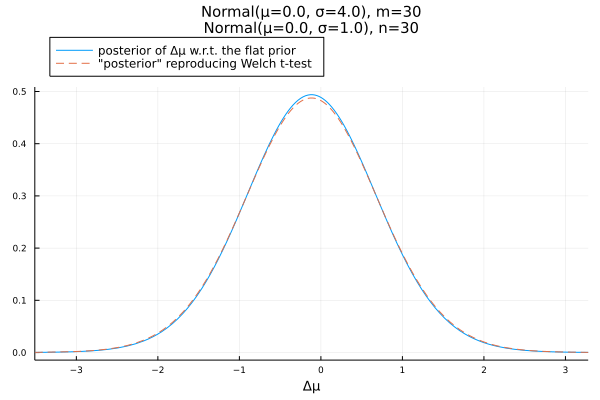

In [15]:
plot_bayesian_welch(distx, 30, disty, 30)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.5999209112809661
var(x) = 25.49710511258687
var(y) = 1.7462055403929169
degree_of_freedom_welch(x, y) = 48.5460469014245
(min(m, n) - 1, (m + n) - 2) = (19, 58)


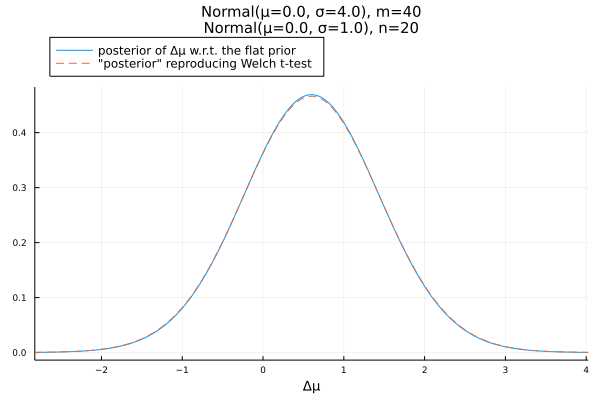

In [16]:
plot_bayesian_welch(distx, 40, disty, 20)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.9088591297675067
var(x) = 23.728598991320013
var(y) = 1.249698412305868
degree_of_freedom_welch(x, y) = 20.007076755454136
(min(m, n) - 1, (m + n) - 2) = (19, 58)


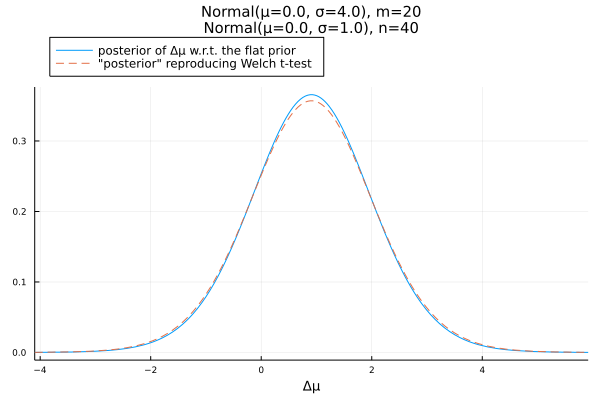

In [17]:
plot_bayesian_welch(distx, 20, disty, 40)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = -0.8717257663592108
var(x) = 19.77859898148583
var(y) = 1.0105046389746013
degree_of_freedom_welch(x, y) = 65.01301994752107
(min(m, n) - 1, (m + n) - 2) = (59, 118)


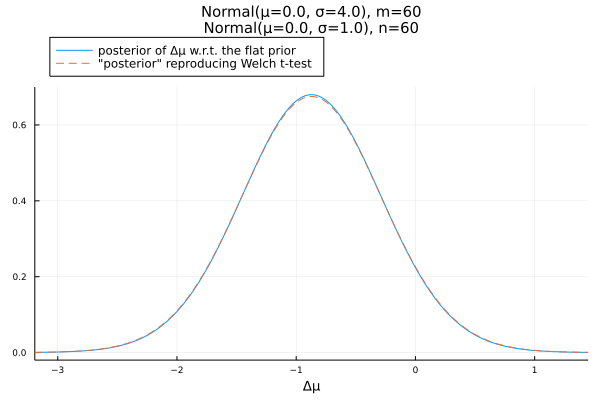

In [18]:
plot_bayesian_welch(distx, 60, disty, 60)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = -0.3024705258317939
var(x) = 13.179984018323038
var(y) = 0.8494788573451595
degree_of_freedom_welch(x, y) = 97.40118237231889
(min(m, n) - 1, (m + n) - 2) = (39, 118)


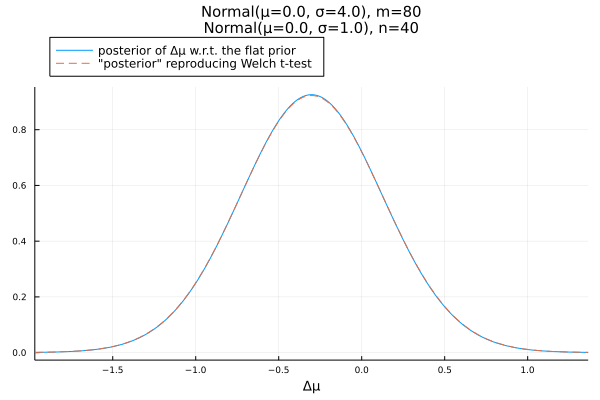

In [19]:
plot_bayesian_welch(distx, 80, disty, 40)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 1.0585880526614289
var(x) = 13.113498705897017
var(y) = 0.8004870985003731
degree_of_freedom_welch(x, y) = 41.39796899824357
(min(m, n) - 1, (m + n) - 2) = (39, 118)


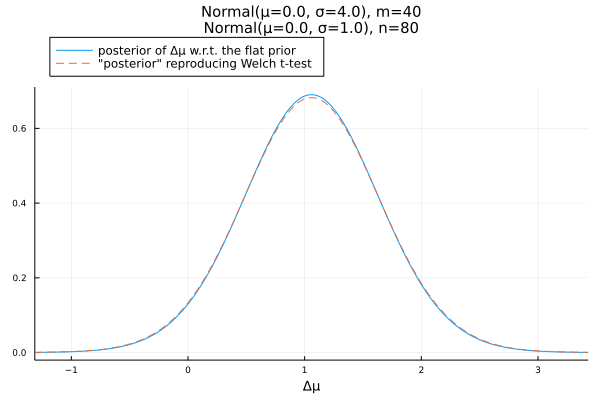

In [20]:
plot_bayesian_welch(distx, 40, disty, 80)

## 異なる２つのガンマ分布でデータを生成した場合

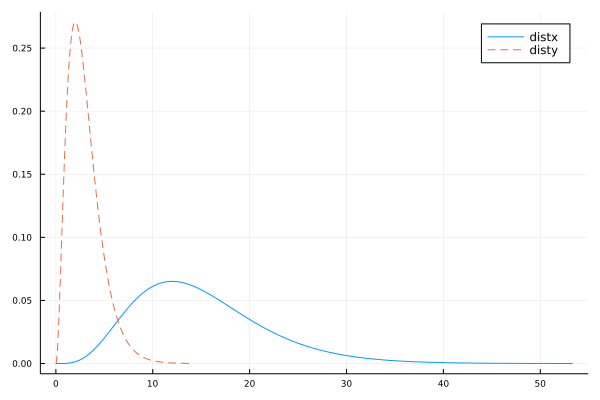

In [21]:
distx = Gamma(5, 3)
disty = Gamma(3, 1)
plot(distx; label="distx")
plot!(disty; label="disty", ls=:dash)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 9.090304695527482
var(x) = 25.300362354405326
var(y) = 5.540696701265138
degree_of_freedom_welch(x, y) = 8.507692924812865
(min(m, n) - 1, (m + n) - 2) = (6, 12)


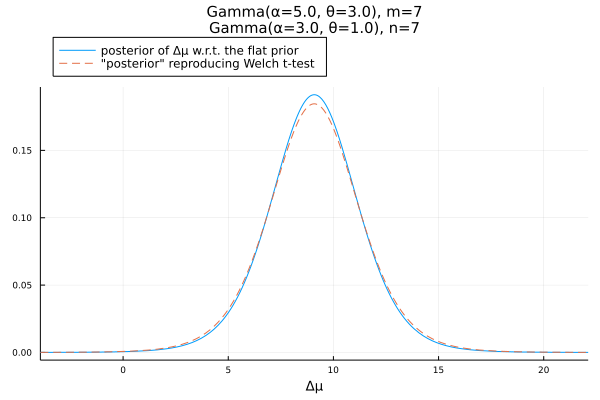

In [22]:
plot_bayesian_welch(distx, 7, disty, 7)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 10.434339622131288
var(x) = 34.5810154688522
var(y) = 4.452581318850626
degree_of_freedom_welch(x, y) = 12.3842879747174
(min(m, n) - 1, (m + n) - 2) = (4, 13)


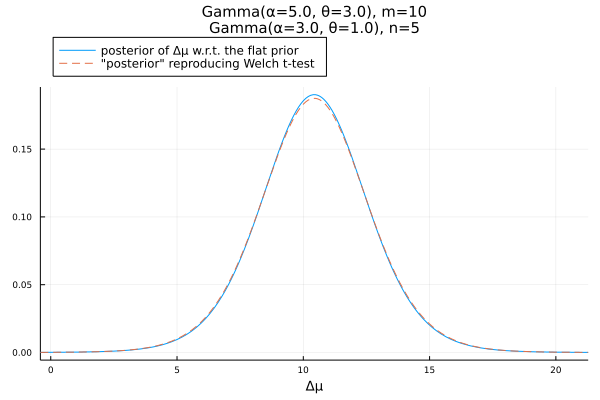

In [23]:
plot_bayesian_welch(distx, 10, disty, 5)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 10.281067730796046
var(x) = 20.92276902076177
var(y) = 1.3694171482343604
degree_of_freedom_welch(x, y) = 4.264058413649293
(min(m, n) - 1, (m + n) - 2) = (4, 13)


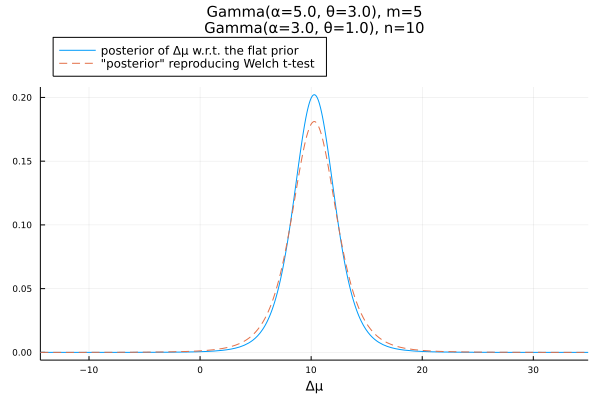

In [24]:
plot_bayesian_welch(distx, 5, disty, 10)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 13.645740422578655
var(x) = 51.48882117610298
var(y) = 3.233794431738776
degree_of_freedom_welch(x, y) = 15.751651717229006
(min(m, n) - 1, (m + n) - 2) = (14, 28)


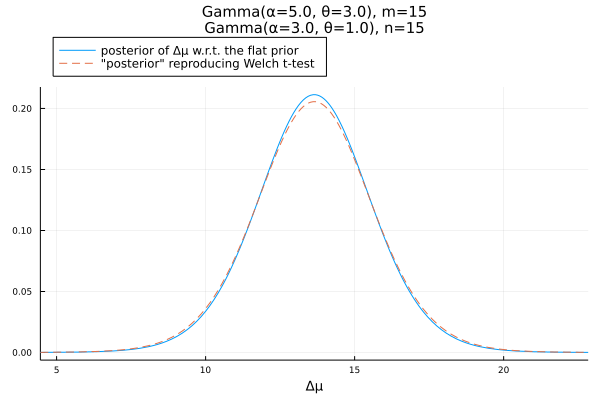

In [25]:
plot_bayesian_welch(distx, 15, disty, 15)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 11.477887034323853
var(x) = 41.996270018287966
var(y) = 2.4988456372250383
degree_of_freedom_welch(x, y) = 23.100557063384727
(min(m, n) - 1, (m + n) - 2) = (9, 28)


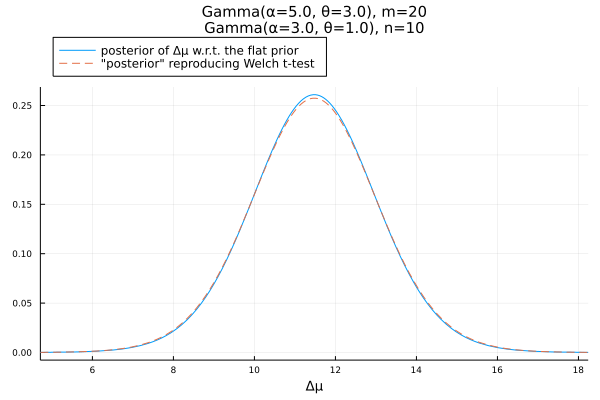

In [26]:
plot_bayesian_welch(distx, 20, disty, 10)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 6.4572189423217985
var(x) = 15.825743434317019
var(y) = 3.636150383767801
degree_of_freedom_welch(x, y) = 11.117135420947363
(min(m, n) - 1, (m + n) - 2) = (9, 28)


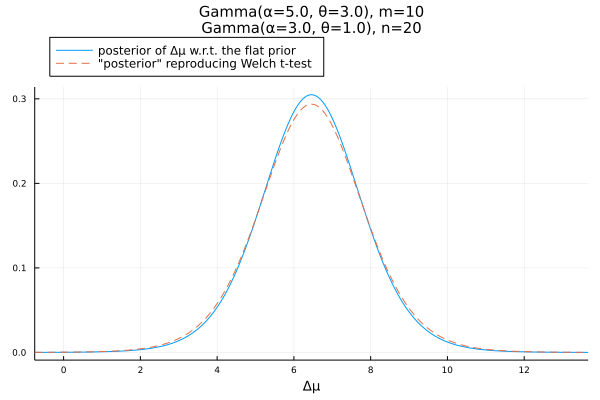

In [27]:
plot_bayesian_welch(distx, 10, disty, 20)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 13.571667318066845
var(x) = 43.325695887515465
var(y) = 2.7854439908941893
degree_of_freedom_welch(x, y) = 32.713517744947225
(min(m, n) - 1, (m + n) - 2) = (29, 58)


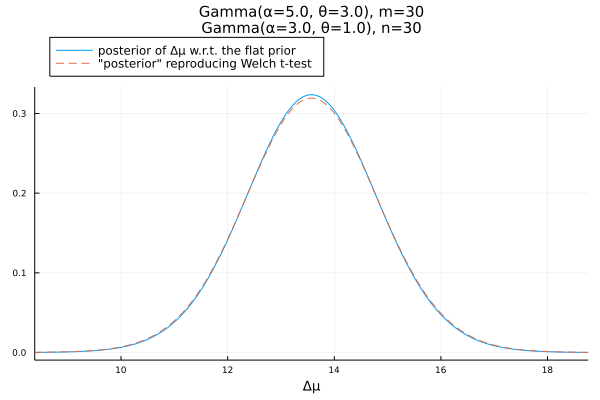

In [28]:
plot_bayesian_welch(distx, 30, disty, 30)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 12.147289250402943
var(x) = 32.672128905574844
var(y) = 2.266126769592661
degree_of_freedom_welch(x, y) = 48.64900062243568
(min(m, n) - 1, (m + n) - 2) = (19, 58)


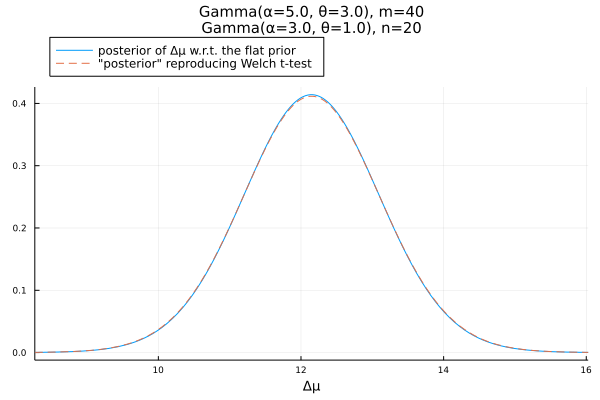

In [29]:
plot_bayesian_welch(distx, 40, disty, 20)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 12.209879389154619
var(x) = 28.860403803506248
var(y) = 2.1834975744440137
degree_of_freedom_welch(x, y) = 20.45041889407447
(min(m, n) - 1, (m + n) - 2) = (19, 58)


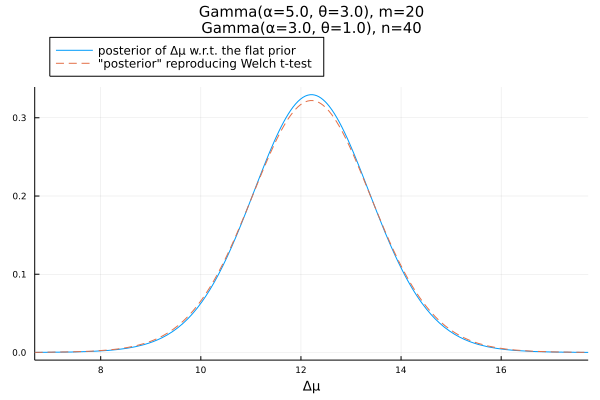

In [30]:
plot_bayesian_welch(distx, 20, disty, 40)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 10.601251047807176
var(x) = 25.75890286405217
var(y) = 2.4412479057713297
degree_of_freedom_welch(x, y) = 70.08365876792469
(min(m, n) - 1, (m + n) - 2) = (59, 118)


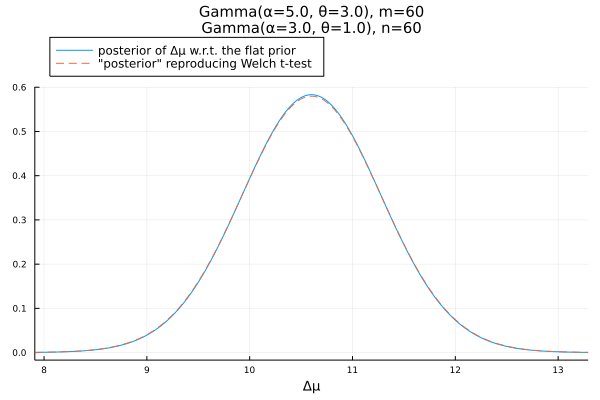

In [31]:
plot_bayesian_welch(distx, 60, disty, 60)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 12.230308268745652
var(x) = 27.576620264628023
var(y) = 2.317937572009413
degree_of_freedom_welch(x, y) = 101.95716978042162
(min(m, n) - 1, (m + n) - 2) = (39, 118)


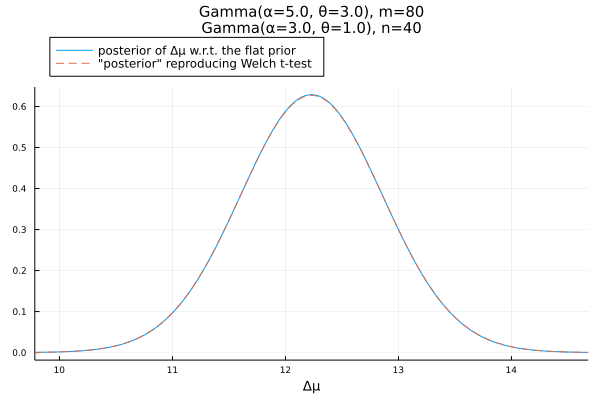

In [32]:
plot_bayesian_welch(distx, 80, disty, 40)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 11.289184043797679
var(x) = 38.31176109499066
var(y) = 2.293679486928542
degree_of_freedom_welch(x, y) = 41.35153781522111
(min(m, n) - 1, (m + n) - 2) = (39, 118)


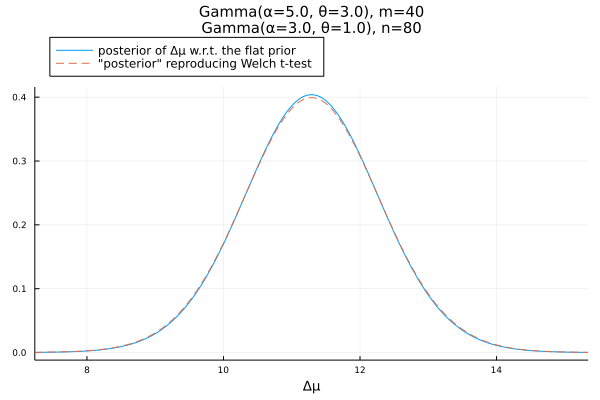

In [33]:
plot_bayesian_welch(distx, 40, disty, 80)

## Welchのt検定での自由度の分布

In [34]:
using Random: rand!

function plot_dist_df_welch(distx, m, disty, n; L=10^6,
        title="m=$m, n=$n", kwargs...)
    tmpx = [Vector{Float64}(undef, m) for _ in 1:Threads.nthreads()]
    tmpy = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    df = Vector{Float64}(undef, L)
    Threads.@threads for i in 1:L
        x = rand!(distx, tmpx[Threads.threadid()])
        y = rand!(distx, tmpy[Threads.threadid()])
        df[i] = degree_of_freedom_welch(x, y)
    end
    
    stephist(df; norm=true, label="df")
    plot!(xlim = (min(m,n)-1-0.5, m+n-2+0.5))
    plot!(legend=:topleft)
    title!(title)
    plot!(; kwargs...)
end

function plot_dists_df_welch(distx, disty, mns; L=10^6, kwargs...)
    @assert length(mns) == 6
    PP = []
    for (m, n) in mns
        P = plot_dist_df_welch(distx, m, disty, n; L, kwargs...)
        push!(PP, P)
    end
    plot(PP...; layout=(2, 3), size=(800, 400))
    plot!(plot_title="distx=$(distname(distx)),  disty=$(distname(disty))")
end

plot_dists_df_welch (generic function with 1 method)

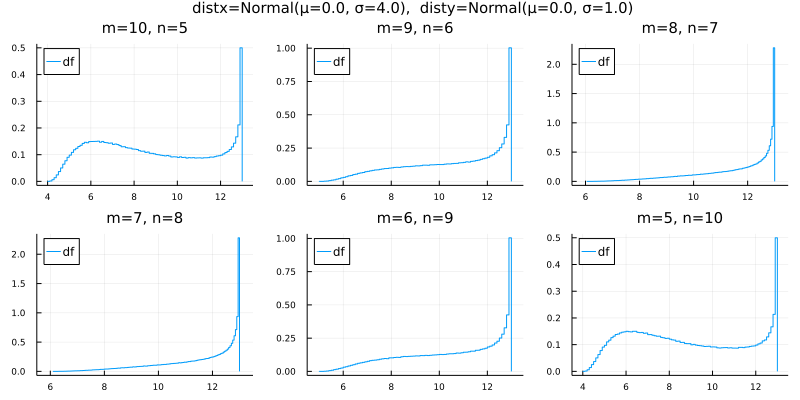

In [35]:
mns = [(10-i, 5+i) for i in 0:5]
plot_dists_df_welch(Normal(0,4), Normal(0,1), mns)

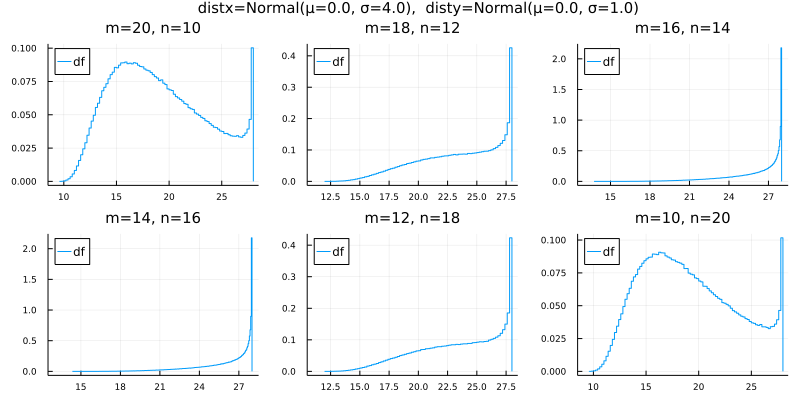

In [36]:
mns = [(20-i, 10+i) for i in 0:2:10]
plot_dists_df_welch(Normal(0,4), Normal(0,1), mns)

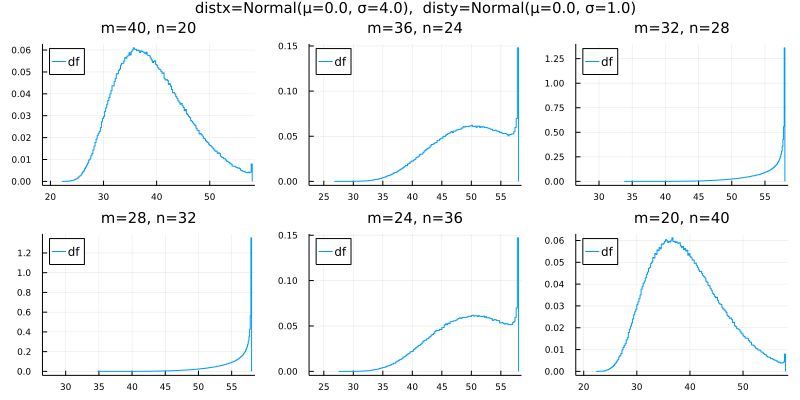

In [37]:
mns = [(40-i, 20+i) for i in 0:4:20]
plot_dists_df_welch(Normal(0,4), Normal(0,1), mns)

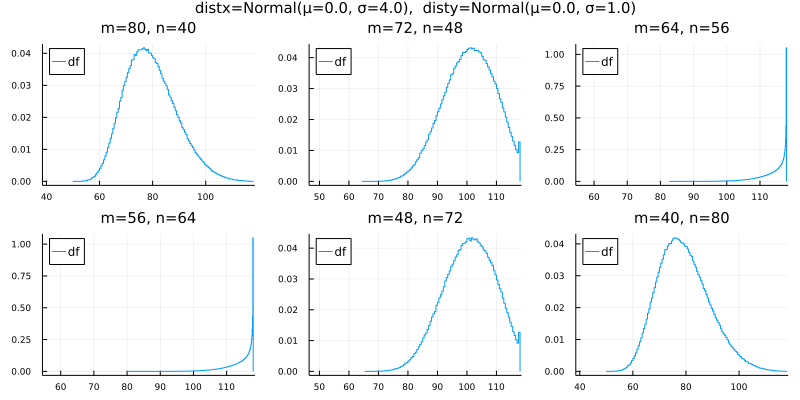

In [38]:
mns = [(80-i, 40+i) for i in 0:8:40]
plot_dists_df_welch(Normal(0,4), Normal(0,1), mns)

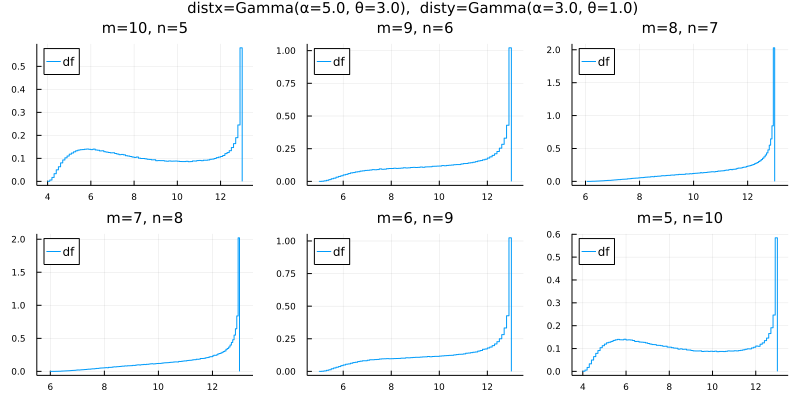

In [39]:
mns = [(10-i, 5+i) for i in 0:5]
plot_dists_df_welch(Gamma(5,3), Gamma(3,1), mns)

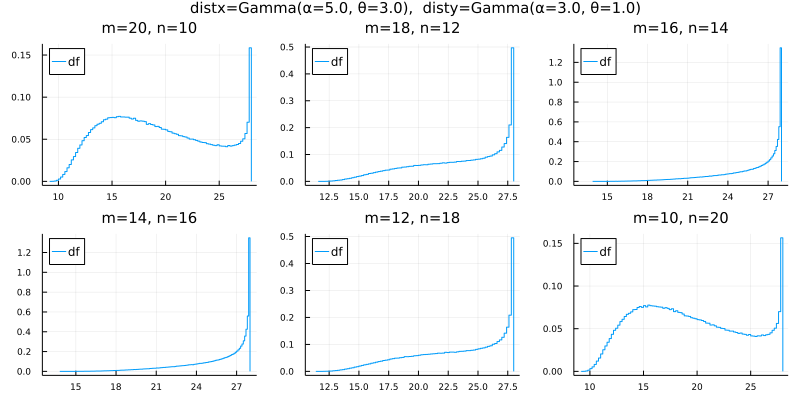

In [40]:
mns = [(20-i, 10+i) for i in 0:2:10]
plot_dists_df_welch(Gamma(5,3), Gamma(3,1), mns)

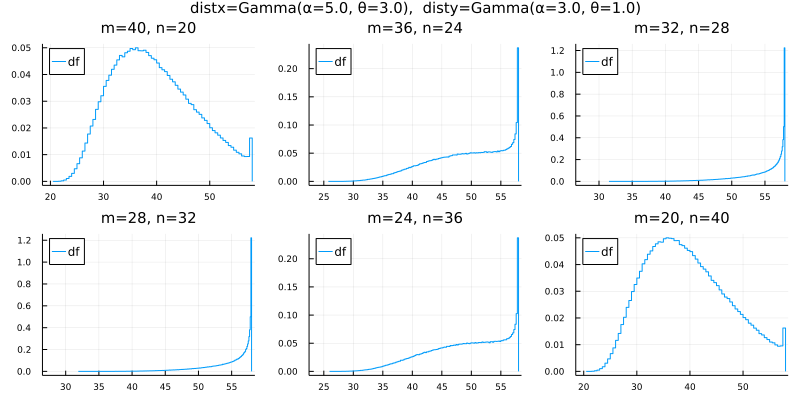

In [41]:
mns = [(40-i, 20+i) for i in 0:4:20]
plot_dists_df_welch(Gamma(5,3), Gamma(3,1), mns)

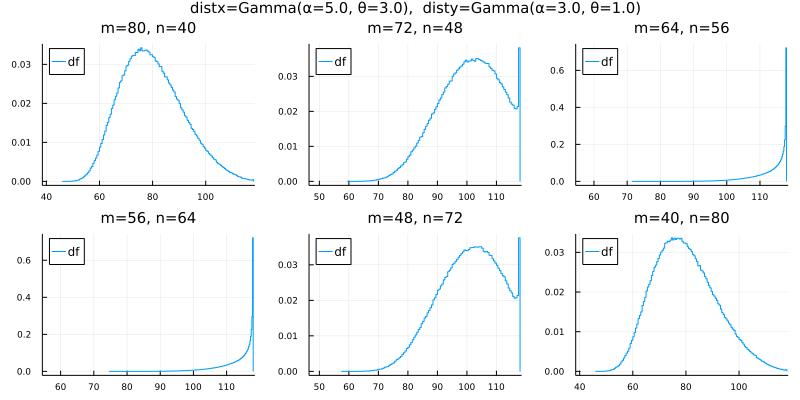

In [42]:
mns = [(80-i, 40+i) for i in 0:8:40]
plot_dists_df_welch(Gamma(5,3), Gamma(3,1), mns)